In [1]:
library(AppliedPredictiveModeling)
data(concrete)

In [2]:
library(plyr)
averaged <- ddply(mixtures,.(Cement,BlastFurnaceSlag,FlyAsh,Water,
                            Superplasticizer,CoarseAggregate,FineAggregate,Age),
                 function(x) c(CompressiveStrength=mean(x$CompressiveStrength)))

In [3]:
library(caret)
set.seed(830)
trn_id <- createDataPartition(averaged$CompressiveStrength,p=3/4,list=F)
trn <- averaged[trn_id,]
vld <- averaged[-trn_id,]

Loading required package: lattice
Loading required package: ggplot2


In [21]:
# Get mixtures at 28 days 
trn_sub <- subset(trn, Age == 28)

# Center and scale the data to use dissimilarity sampling
trn_scaled <- predict(
    preProcess(trn_sub[, -(8:9)], c("center", "scale")), 
    trn_sub[, 1:7])

In [22]:
# Randomly select a few mixtures as a starting pool
# a single random mixture is selected to initialize the maximum dissimilarity sampling process
set.seed(830)
init_id <- sample(1:nrow(trn_sub),1)
init_mixture <- trn_scaled[init_id,1:7]

In [23]:
# After this, the maximum dissimilarity sampling method from Sect. 4.3 
# selects 14 more mixtures to complete a diverse set of starting points for the search algorithms:
pool <- trn_scaled
max_diff_id <- maxDissim(init_mixture,pool,14)
init_points <- c(init_id,max_diff_id)
init_mixtures <- trn_sub[init_points,1:7]

In [26]:
#remove waters
init_mix <- init_mixtures[,-4]

The function below checks to make sure that 
- (a) the proportions are between 0 and 1 and 
- (b) the proportion of water does not fall below 5 %.

If these conditions are violated, the function returns a large positive number which the search procedure will avoid (as optim is for minimization).

In [27]:
### Create a function to maximize compressive strength* while keeping
### the predictor values as mixtures. Water (in x[7]) is used as the slack variable. 
modelPrediction <- function(x, mod)
  {
  ## Check to make sure the mixture proportions are
  ## in the correct range
  if(x[1] < 0 | x[1] > 1) return(10^38)
  if(x[2] < 0 | x[2] > 1) return(10^38)
  if(x[3] < 0 | x[3] > 1) return(10^38)
  if(x[4] < 0 | x[4] > 1) return(10^38)
  if(x[5] < 0 | x[5] > 1) return(10^38)
  if(x[6] < 0 | x[6] > 1) return(10^38)
 
  ## Determine the water proportion242 10 Case Study: Compressive Strength of Concrete Mixtures
  x <- c(x, 1 - sum(x))
 
  ## Check the water range
  if(x[7] < 0.05) return(10^38)
 
  ## Convert the vector to a data frame, assign names
  ## and fix age at 28 days
  tmp <- as.data.frame(t(x))
  names(tmp) <- c('Cement','BlastFurnaceSlag','FlyAsh',
  'Superplasticizer','CoarseAggregate',
  'FineAggregate', 'Water')
  tmp$Age <- 28
  ## Get the model prediction, square them to get back to the
  ## original units, then return the negative of the result
  -predict(mod, tmp)
  }

In [30]:
library(parallel)
setDefaultCluster(makeCluster(4))
set.seed(830)
ctrl <- trainControl(method = "repeatedcv",repeats = 5,number=10)
grid_cubist <- expand.grid(
                           committees=c(1,5,10,50,75,100),
                           neighbors=c(0,1,3,5,7,9)
                          )
fit_cubist <- train(CompressiveStrength~.,data=trn,method = "cubist",
                    tuneGrid=grid_cubist,trControl=ctrl)

fit_cubist$bestTune

,committees,neighbors
33,100,3


In [31]:
### For each starting mixture, optimize the Cubist model using
### a simplex search routine

cbResults <- init_mix
cbResults$Water <- NA
cbResults$Prediction <- NA

for(i in 1:nrow(cbResults))
{
  results <- optim(unlist(cbResults[i,1:6]),
                   modelPrediction,
                   method = "Nelder-Mead",
                   control=list(maxit=5000),
                   mod = fit_cubist)
  cbResults$Prediction[i] <- -results$value
  cbResults[i,1:6] <- results$par
}
cbResults$Water <- 1 - apply(cbResults[,1:6], 1, sum)
cbResults <- subset(cbResults, Prediction > 0 & Water > .02)
cbResults <- cbResults[order(-cbResults$Prediction),][1:3,]
cbResults$Model <- "Cubist"

In [33]:
cbResults

,Cement,BlastFurnaceSlag,FlyAsh,Superplasticizer,CoarseAggregate,FineAggregate,Water,Prediction,Model
836,0.2486430,0.612397307,8.609288e-08,0.0213226651,9.756416e-09,0.05716477,0.06047214,135.49004,Cubist
10,0.2400803,0.002094838,5.911865e-03,0.0001476794,4.291221e-01,0.27056296,0.05208027,84.33553,Cubist
717,0.2268725,0.009328538,1.760942e-03,0.0040106908,4.623430e-01,0.24568426,0.05000001,82.98220,Cubist


In [34]:
nnetGrid <- expand.grid(decay = 0.1, size = 27, bag = FALSE)
set.seed(830)
fit_nnet <- train(CompressiveStrength ~ .,
                 data = trn,
                 method = "avNNet",
                 tuneGrid = nnetGrid,
                 preProc = c("center", "scale"),
                 linout = TRUE,
                 trace = FALSE,
                 maxit = 1000,
                 allowParallel = FALSE,
                 trControl = ctrl)
fit_nnet$bestTune

size,decay,bag
27,0.1,FALSE


In [35]:
### Do the same for the neural network model
# Tuning parameter 'bag' was held constant at a value of FALSE
# RMSE was used to select the optimal model using the smallest value.
# The final values used for the model were size = 27, decay = 0.1 and bag = FALSE.

nnetResults <- init_mix
nnetResults$Water <- NA
nnetResults$Prediction <- NA

for(i in 1:nrow(nnetResults))
{
  results <- optim(unlist(nnetResults[i, 1:6,]),
                   modelPrediction,
                   method = "Nelder-Mead",
                   control=list(maxit=5000),
                   mod = fit_nnet)
  nnetResults$Prediction[i] <- -results$value
  nnetResults[i,1:6] <- results$par
}
nnetResults$Water <- 1 - apply(nnetResults[,1:6], 1, sum)
nnetResults <- subset(nnetResults, Prediction > 0 & Water > .02)
nnetResults <- nnetResults[order(-nnetResults$Prediction),][1:3,]
nnetResults$Model <- "NNet"

In [37]:
nnetResults

,Cement,BlastFurnaceSlag,FlyAsh,Superplasticizer,CoarseAggregate,FineAggregate,Water,Prediction,Model
10,0.2768461,0.10815548,1.935552e-10,0.008202413,0.3431825,0.2038984,0.05971514,93.76151,NNet
113,0.2666234,0.10734854,3.739671e-10,0.007849855,0.3475017,0.2102354,0.06044111,93.62152,NNet
836,0.1591788,0.08797033,2.782343e-02,0.004321313,0.3476385,0.3219479,0.05111974,89.24696,NNet


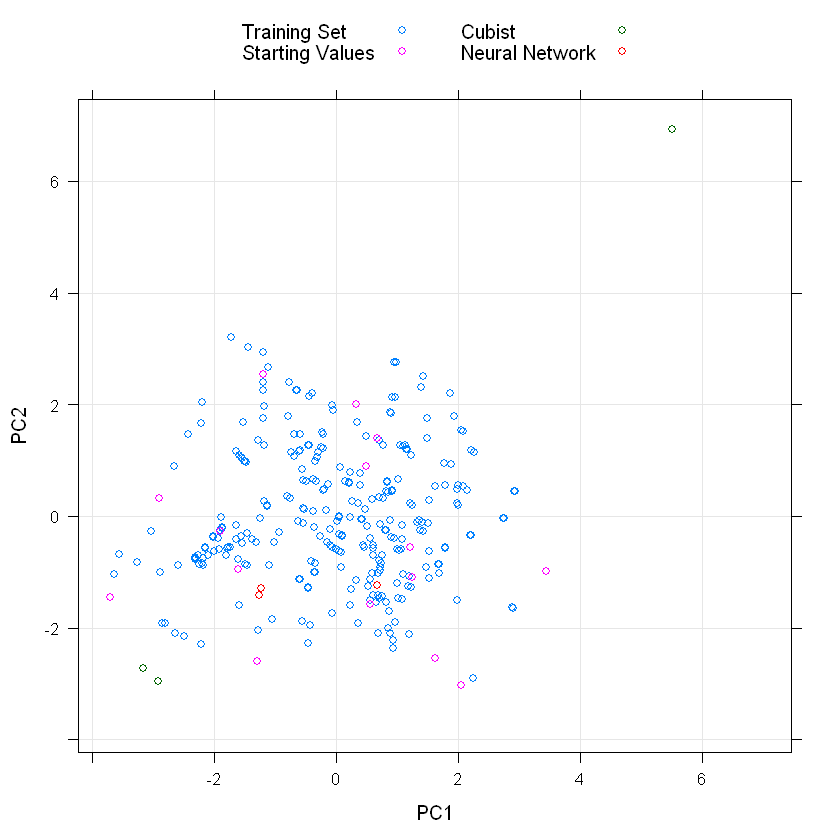

In [38]:
### Convert the predicted mixtures to PCA space and plot

fit_pca <- preProcess(trn_sub[, 1:7], "pca")
pca1 <- predict(fit_pca, trn_sub[, 1:7])
pca1$Data <- "Training Set"
pca1$Data[init_points] <- "Starting Values"
pca3 <- predict(fit_pca, cbResults[, names(trn_sub[, 1:7])])
pca3$Data <- "Cubist"
pca4 <- predict(fit_pca, nnetResults[, names(trn_sub[, 1:7])])
pca4$Data <- "Neural Network"

pcaData <- rbind(pca1, pca3, pca4)
pcaData$Data <- factor(pcaData$Data,
                       levels = c("Training Set","Starting Values",
                                  "Cubist","Neural Network"))

lim <- extendrange(pcaData[, 1:2])

xyplot(PC2 ~ PC1, 
       data = pcaData, 
       groups = Data,
       auto.key = list(columns = 2),
       xlim = lim, 
       ylim = lim,
       type = c("g", "p"))